<a href="https://colab.research.google.com/github/j88620714/DataScience/blob/master/HW4-6/PCA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install gspread
!pip install oauth2client
!pip install Pillow
!pip install -U -q PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1_7FyladR7eGnmUjsCvNF1XnpVZpuNGXm' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  #fname = os.path.join(local_download_path, f['title'])
  fname = os.path.join('/content', f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  #f_.GetContentFile(fname)
!ls "/root/data"

從試算表中把所需交通車禍事件的資料抓下來，因為要分析死亡車禍，在此只抓107年-臺北市A1及A2類交通事故明細。

In [0]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from oauth2client.client import GoogleCredentials
from google.colab import auth
from google.colab import files
auth.authenticate_user()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
from IPython.display import Image
from wordcloud import WordCloud, ImageColorGenerator
import re
import jieba
import time
import pandas as pd
import math
from collections import Counter
import codecs
from sklearn.decomposition import PCA
from mlxtend.preprocessing import TransactionEncoder
from gspread_dataframe import get_as_dataframe, set_with_dataframe

gc = gspread.authorize(GoogleCredentials.get_application_default())
sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1A3V6ncj7VLNDiDkchaYPIYmqrA0trkEj8L-tHoaAyZs/edit#gid=154609684')
wks4 = sh.worksheet("data3")
wks3 = sh.worksheet("對照表")

df = get_as_dataframe(wks4,parse_dates=True,usecols=[1,2],header=None)
df.head()





For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



,1,2
0,類別,內容
1,死亡,死亡死亡死亡死亡大同區台北橋汽車道往三重大型重型機車2(250-550C.C.)自用小貨車計...
2,死亡,死亡死亡大同區民族西路284號與民族西路口普通重型機車行人男性男性知天命古稀晴天0多岔路交叉口附近
3,死亡,死亡死亡死亡大同區忠孝橋機車道號往三重機車道普通重型機車0乘客男性動物、堆置物女性至學至學至...
4,死亡,死亡死亡大同區台北橋機車引道三重往台北普通重型機車0男性動物、堆置物知天命至學晴天40Km/...


從對照表中抓取想要分析的特別詞彙，並把他抓下來備用，其中包括車種、天氣型態、道路型態、受傷程度、事故位置等，有利於陳述每起車禍事件的特徵，並作為之後找關聯性的標籤。(出現英文版是因為最後畫圖的時候，中文字一直顯示不出來.....)


In [0]:
label = get_as_dataframe(wks3,parse_dates=True,usecols=[5,6],header=None)
label[:69]

,5,6
0,受傷,Hurt
1,死亡,Die
2,公營公車,Public Bus
3,民營公車,Private Bus
4,公營客運,Public Passenger Bus
5,民營客運,Private Passenger Bus
6,遊覽車,Tour Bus
7,自用大客車,Personal Bus
8,營業用大貨車,Company Large Truck
9,自用大貨車,Personal Large Truck


看那些特定詞彙在車禍事件資料庫中共同出現的車禍事件數，並做成稀疏矩陣，如果是對角線(即為相同的詞對應到的方格)，則會取該詞語出現在總事件中的次數為矩陣中的值，因為這樣可以方便我們在接下來圖上設定標籤大小時使用。

In [0]:
matrix = []
df1 = df[:75]
label1 = label[:69]
#print(len(df1))
for i in range(len(label1)):
  matrix.append([])
  for j in range(len(label1)):
    ct = 0 
    for k in df1[2]:
      if(label1[5][i] in k)  & (label1[5][j] in k ):
        ct+=1
    matrix[i].append(ct)    
matrix = pd.DataFrame(matrix)

matrix.columns = label1[5]
matrix.index = label1[5]
pd.set_option('display.max_columns', 69)
pd.set_option('display.max_rows', 69)
matrix.head(69)


5,受傷,死亡,公營公車,民營公車,公營客運,民營客運,遊覽車,自用大客車,營業用大貨車,自用大貨車,營業用半聯結車,營業用曳引車,計程車,租賃車,自用小客車,營業用小貨車,自用小貨車,大型重型機車1(550C.C.以上),大型重型機車2(250-550C.C.),普通重型機車,腳踏自行車,行人,乘客,男性,女性,暴雨,雨天,陰天,晴天,三岔路,四岔路,多岔路,隧道,地下道,橋樑,涵洞,高架道路,彎曲路及附近,坡路,巷弄,直路,圓環,廣場,交叉路口內,交叉口附近,機車待轉區,機車停等區,交通島,迴轉道,快車道,慢車道,一般車道,公車專用道,機車專用道,機車優先道,路肩、路緣,行人穿越道,穿越道附近,人行道,至學,而立,不惑,知天命,耳順,耄耋,古稀,50Km/hr,40Km/hr,30Km/hr
5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
受傷,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
死亡,0,74,0,2,0,0,1,0,0,0,1,0,4,5,25,0,16,2,5,37,6,25,8,70,33,0,11,12,51,10,30,2,1,0,4,0,1,1,0,1,24,0,0,25,16,0,1,2,2,4,1,20,0,3,0,0,2,0,0,39,22,17,24,12,10,15,52,13,7
公營公車,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
民營公車,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,2,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,2,1,1,0
公營客運,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
民營客運,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
遊覽車,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
自用大客車,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
營業用大貨車,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


將字詞依照共同線的頻率降維呈現在圖表中，並讓越相關的字詞離的靠越近，相互聯繫的線條也較粗。從圖表中我們可以發現外圍許多名詞都十分獨立，和其他詞彙相關性不高。

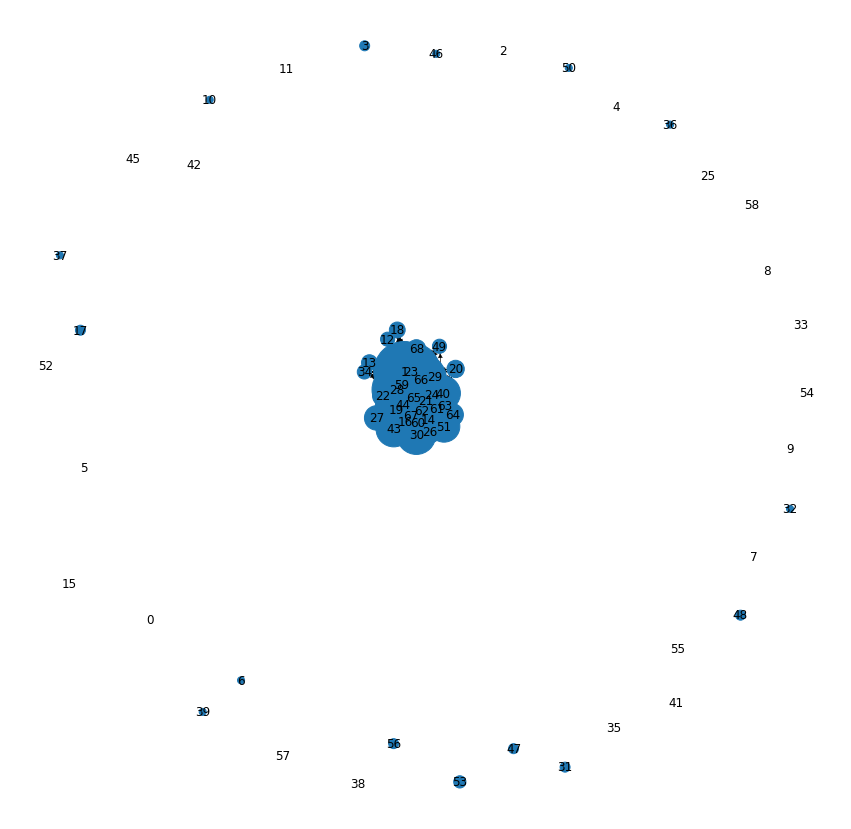

In [0]:
import networkx as nx
import matplotlib.font_manager as fm
import matplotlib
plt.subplots(figsize=(15,15))
G = nx.DiGraph()
G.add_nodes_from(range(len(label1[5])))
widths = [] 
sizes = []
for i in range(len(label1[5])):
  for j in range(len(label1[5])):
    w = matrix[label1[5][i]][label1[5][j]]
    if i==j:
      sizes.append(w*50)
      continue
    if w<=3:
      continue
    widths.append(w/10)
    #if w==0:
    #  w=0.1
    #print(type(w))
    
    G.add_edges_from([(i,j)], weight=1/w)
nx.draw(G,with_labels=True,width=widths,node_size = sizes)


由上圖觀察出較無關的詞彙後，我們將外圍的詞彙刪除，取剩餘的關鍵詞再進行分析。

In [32]:
label2=label.drop([17,35,11,45,7,2,8,32,55,38,31,57,9,5,56,53,54,42,52,15,58,50,0,4,25,33,37,3,6,48,46,39,36,47,30,41,10,12,13,18])
label2=label2[:29]
label2.head(29)



,5,6
1,死亡,Die
14,自用小客車,Personal Passenger Car
16,自用小貨車,Personal Small Truck
19,普通重型機車,Motocycle
20,腳踏自行車,Bike
21,行人,Pedestrian
22,乘客,Passenger
23,男性,Male
24,女性,Female
26,雨天,Rainy


我們將中間關聯性較高的部分進行分析，為了讓畫面更容易於閱讀，我們將結點依照不同名詞類別分別給予不同顏色，有利於我們找出各類別間的性質的相關性。另外，權重與距離之間有log的關係，有助於我們呈現在同一張圖上，較容易判讀。

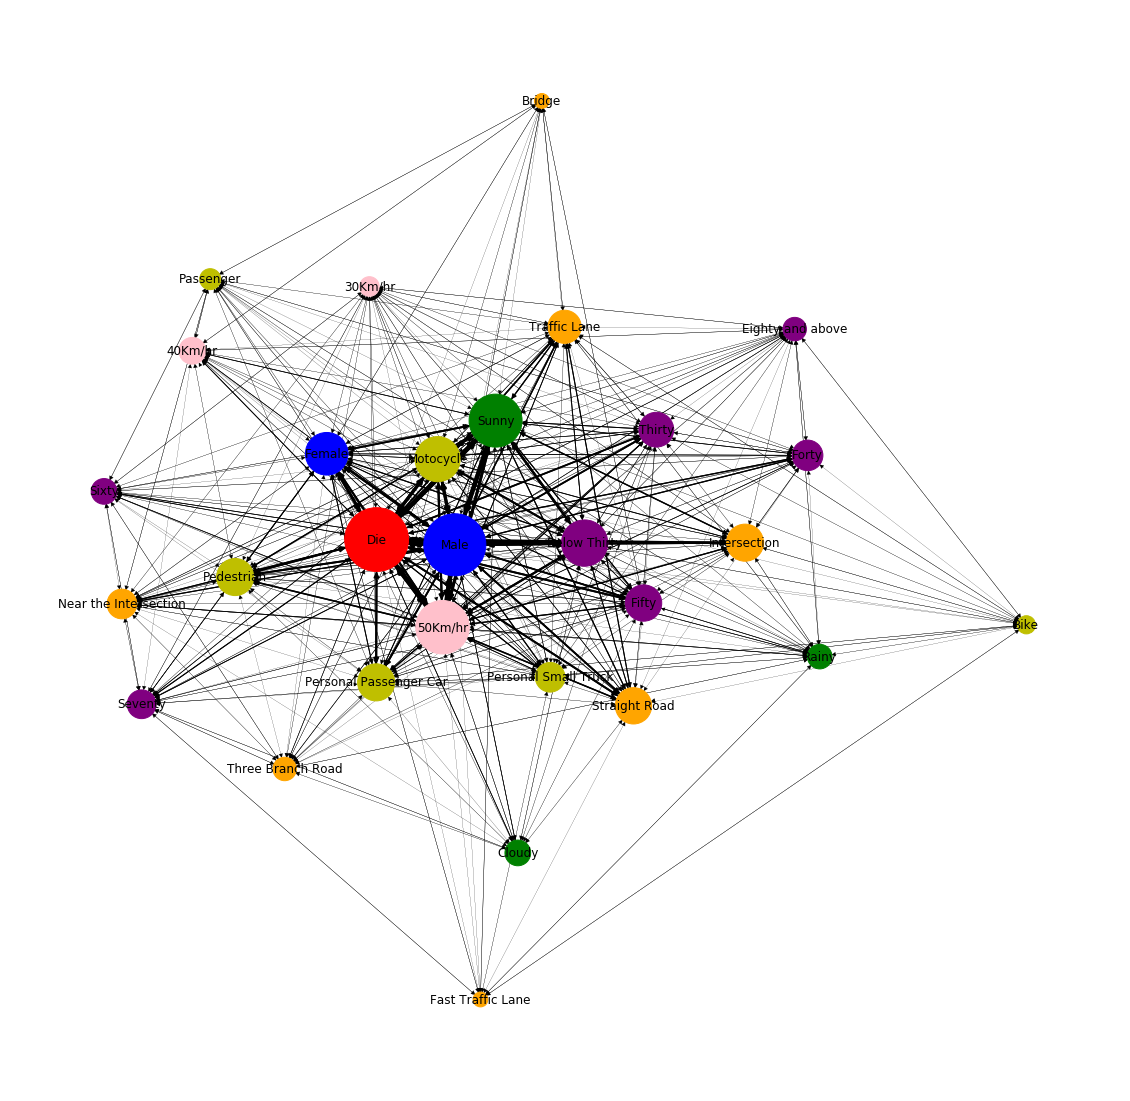

In [0]:
import networkx as nx
import matplotlib.font_manager as fm
import matplotlib
import math
plt.subplots(figsize=(20,20))
G = nx.DiGraph()
#G.add_nodes_from(label2.index.tolist())
G.add_nodes_from(label2[6].tolist())
widths = [] 
sizes = []
for i in label2.index.tolist():
  for j in label2.index.tolist():
    w = matrix[label2[5][i]][label2[5][j]]
    if i==j:
      sizes.append(w*55)
      continue
    if w<=1:
      continue
    widths.append(w/10-0.5)    
    #G.add_edges_from([(i,j)], weight=-25*math.log(1/w))
    G.add_edges_from([(label2[6][i],label2[6][j])], weight=-25*math.log(1/w))
pos = nx.spring_layout(G, k=0.5, iterations=20)
colors=['r','y','y','y','y','y','y','b','b','g','g','g','orange','orange','orange','orange','orange','orange','orange','purple','purple','purple','purple','purple','purple','purple','pink','pink','pink']

nx.draw(G,pos,with_labels=True,width=widths,node_size = sizes,node_color=colors)